## Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, silhouette_samples, pairwise_distances
# from sklearn_extra.cluster import KMedoids
# from kmodes.kprototypes import  KPrototypes
# from kmodes.kmodes import KModes  # For K-Modes

In [31]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [36]:
from sklearn.cluster import AgglomerativeClustering

In [43]:
import plotly.express as px

## Data

In [4]:
data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [5]:
data = data.drop(columns=['FILENAME'])

## Data Cleaning

In [6]:
label_encoder = LabelEncoder()

In [7]:
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

## EDA

In [8]:
print(data.describe())

               URL    URLLength       Domain  DomainLength   IsDomainIP  \
count  4486.000000  4486.000000  4486.000000   4486.000000  4486.000000   
mean   2242.500000    30.853767  2205.345742     20.780874     0.001560   
std    1295.140983    20.904945  1289.242044      7.799517     0.039476   
min       0.000000    13.000000     0.000000      4.000000     0.000000   
25%    1121.250000    23.000000  1080.250000     16.000000     0.000000   
50%    2242.500000    27.000000  2201.500000     19.000000     0.000000   
75%    3363.750000    32.000000  3322.750000     24.000000     0.000000   
max    4485.000000   472.000000  4444.000000     86.000000     1.000000   

               TLD  URLSimilarityIndex  CharContinuationRate  \
count  4486.000000         4486.000000           4486.000000   
mean     70.543469           84.625886              0.873251   
std      47.713744           25.175642              0.198694   
min       0.000000            1.727385              0.142857   
25% 

In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4486 entries, 0 to 4485
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   URL                         4486 non-null   int64  
 1   URLLength                   4486 non-null   int64  
 2   Domain                      4486 non-null   int64  
 3   DomainLength                4486 non-null   int64  
 4   IsDomainIP                  4486 non-null   int64  
 5   TLD                         4486 non-null   int64  
 6   URLSimilarityIndex          4486 non-null   float64
 7   CharContinuationRate        4486 non-null   float64
 8   TLDLegitimateProb           4486 non-null   float64
 9   URLCharProb                 4486 non-null   float64
 10  TLDLength                   4486 non-null   int64  
 11  NoOfSubDomain               4486 non-null   int64  
 12  HasObfuscation              4486 non-null   int64  
 13  NoOfObfuscatedChar          4486 

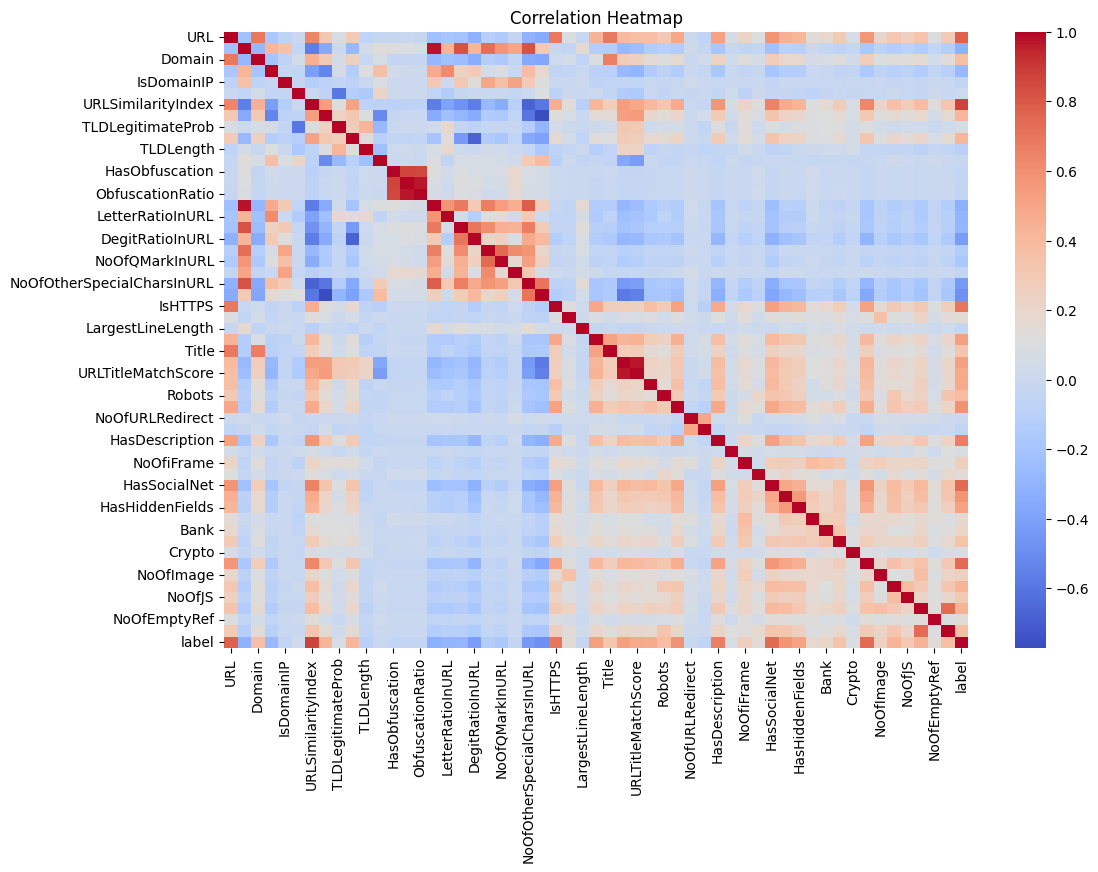

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

drop lowly corrlated values

In [12]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

In [13]:
# Get the correlations of all columns with the label column
correlations_with_label = correlation_matrix['label']

In [14]:
# Filter out columns with correlation between -0.2 and 0.2
columns_to_drop = correlations_with_label[(correlations_with_label > -0.2) & (correlations_with_label < 0.2)].index

In [15]:
# Drop the low-correlation columns
data = data.drop(columns=columns_to_drop)

In [16]:
# Display the remaining columns
print("Remaining columns after dropping low-correlation columns:")
print(data.columns)

Remaining columns after dropping low-correlation columns:
Index(['URL', 'URLLength', 'Domain', 'DomainLength', 'URLSimilarityIndex',
       'CharContinuationRate', 'URLCharProb', 'NoOfLettersInURL',
       'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL',
       'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'HasDescription', 'NoOfiFrame',
       'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'Bank', 'Pay',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfExternalRef', 'label'],
      dtype='object')


In [17]:
# sns.pairplot(data, diag_kind='kde')
# plt.show()

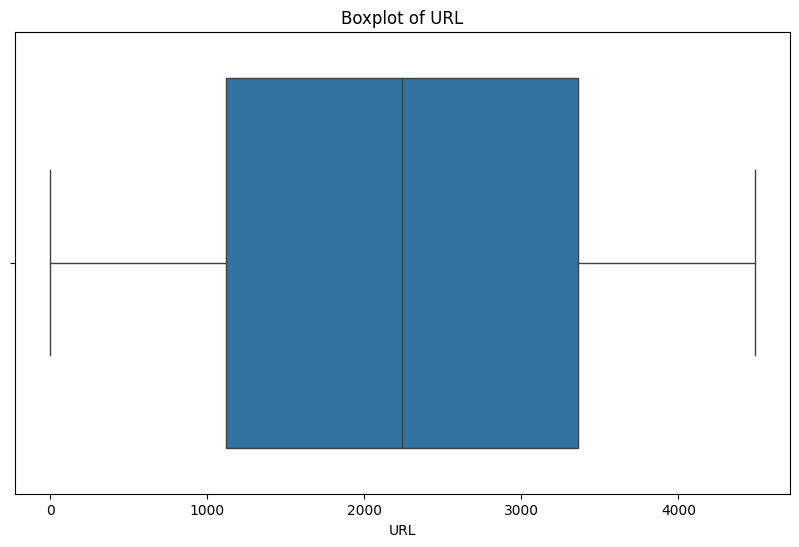

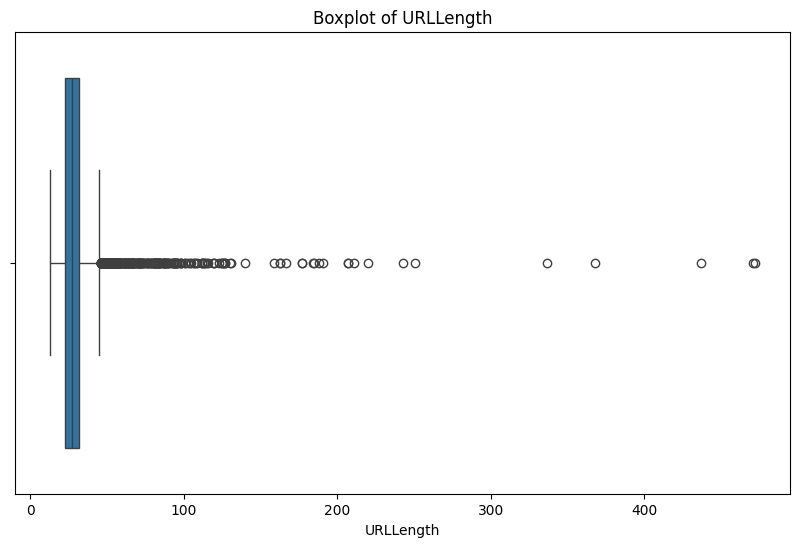

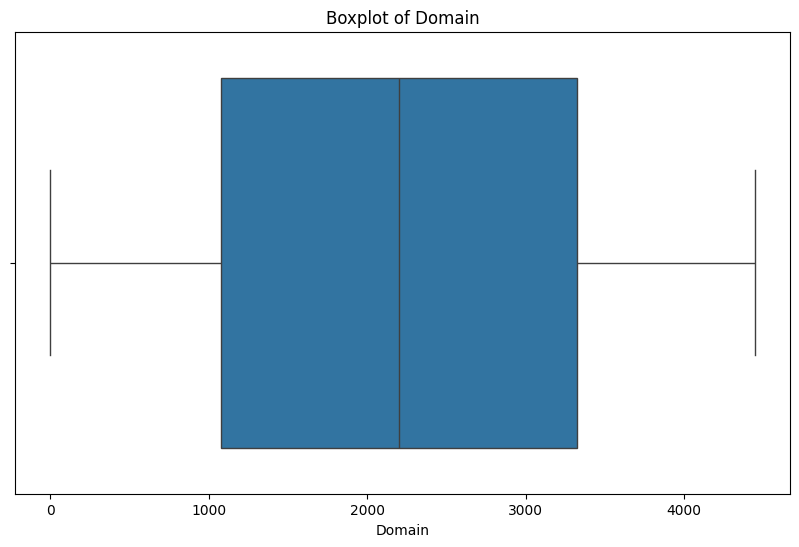

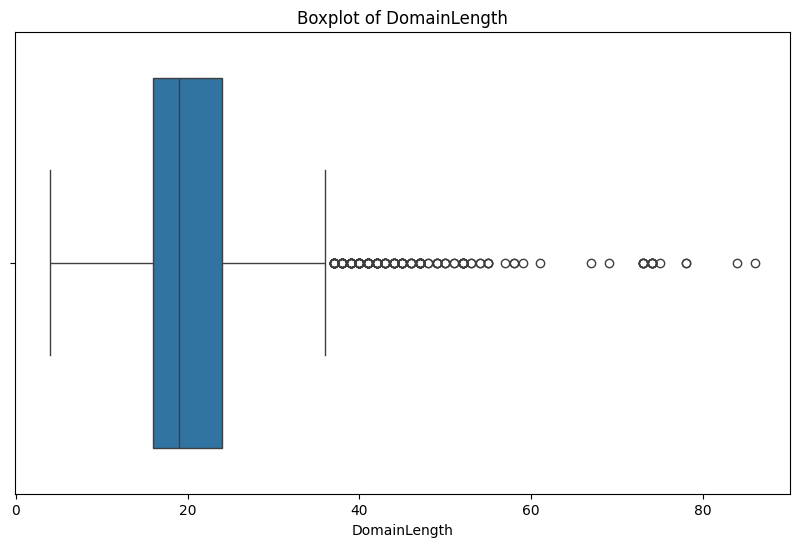

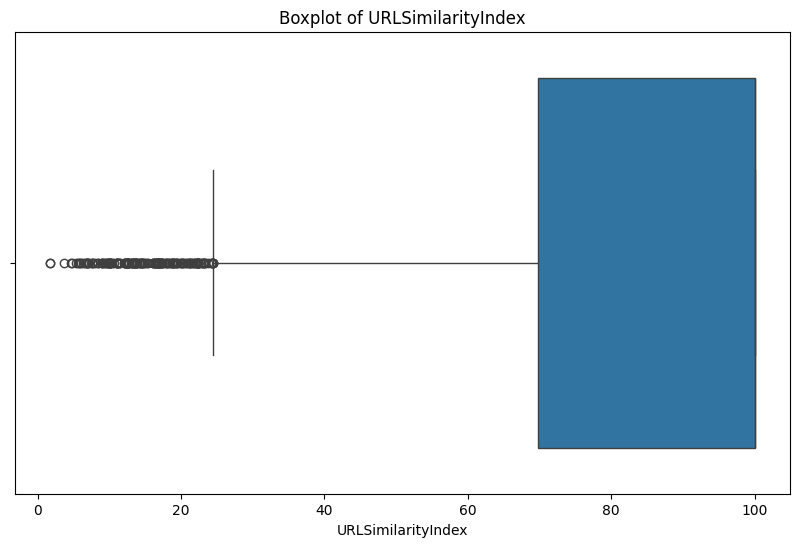

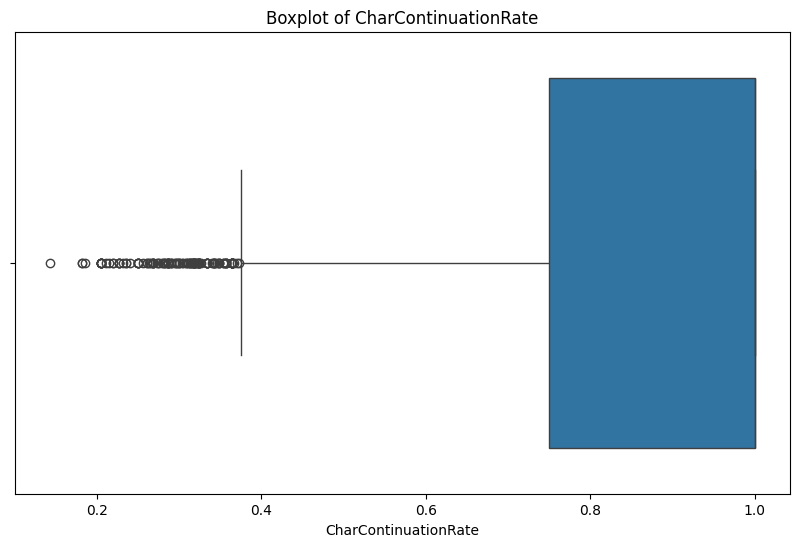

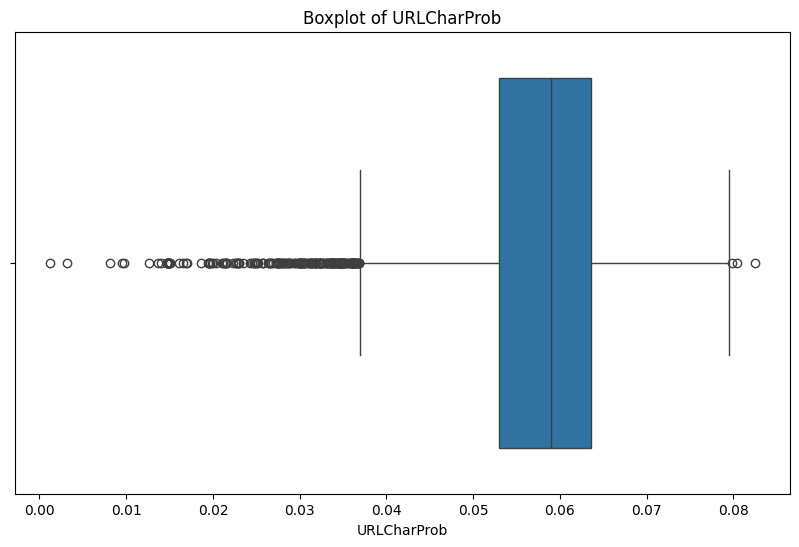

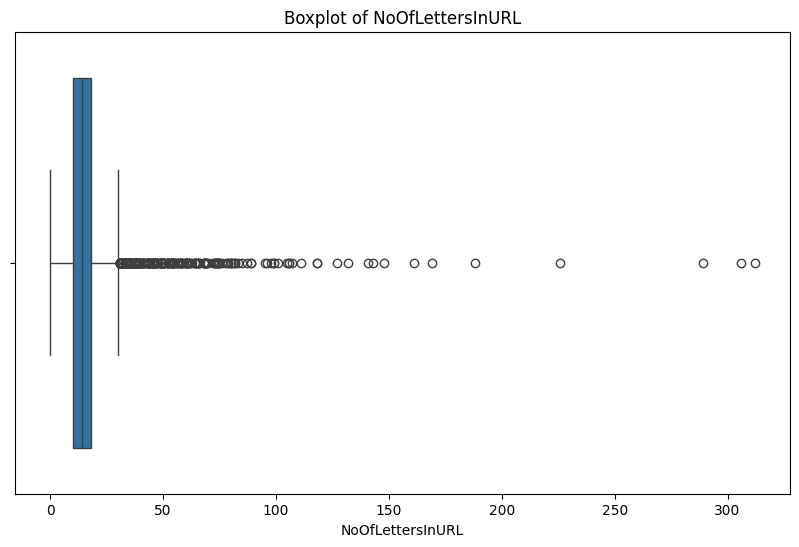

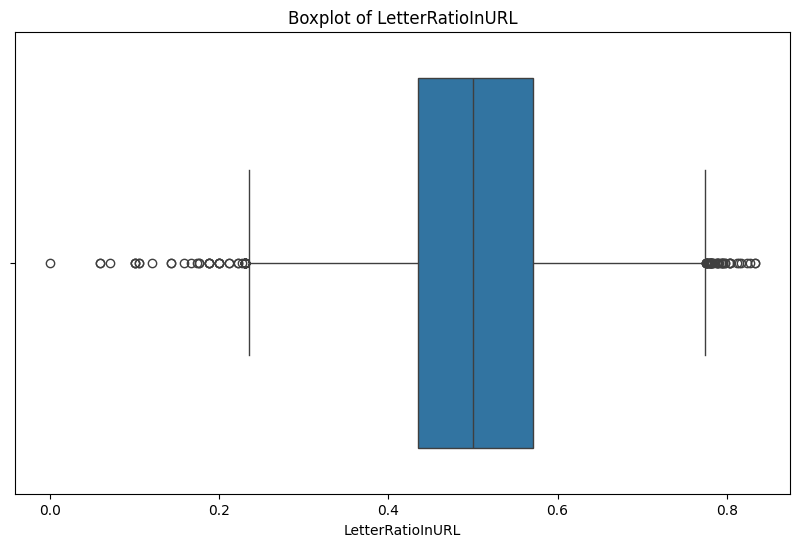

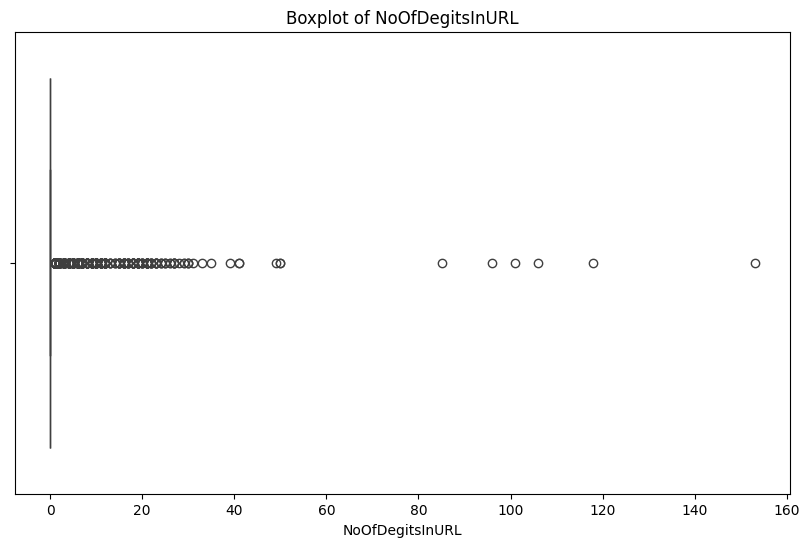

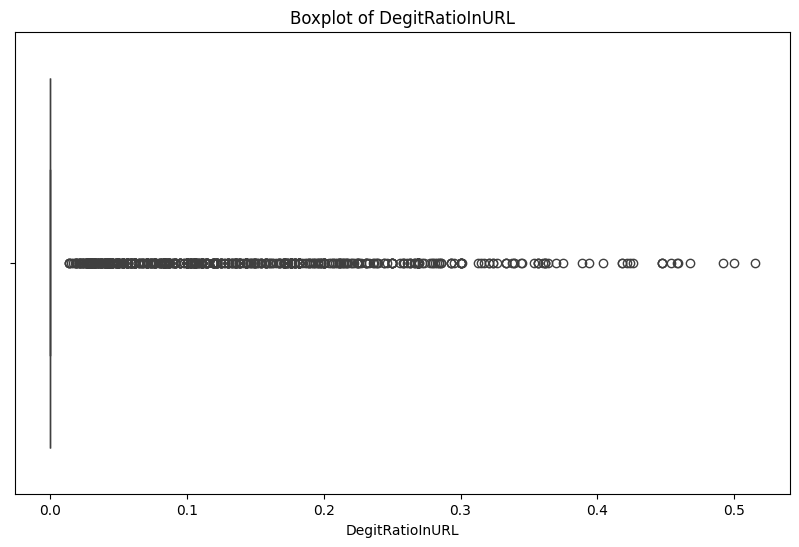

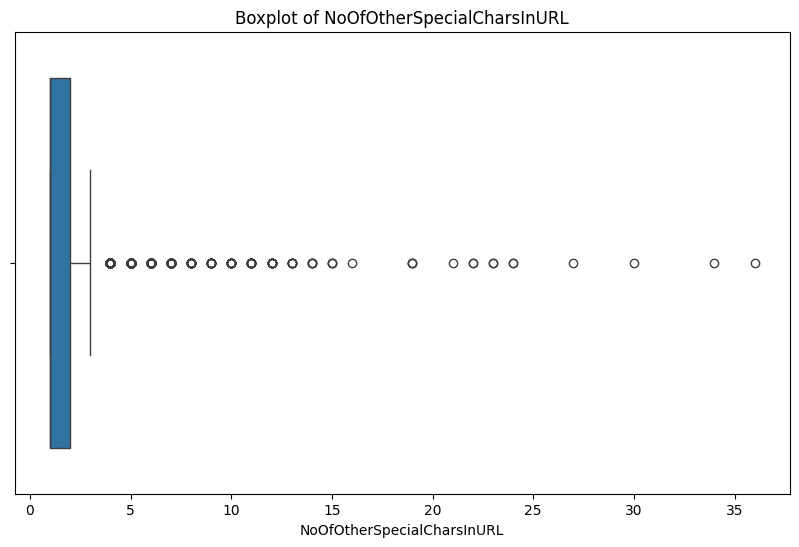

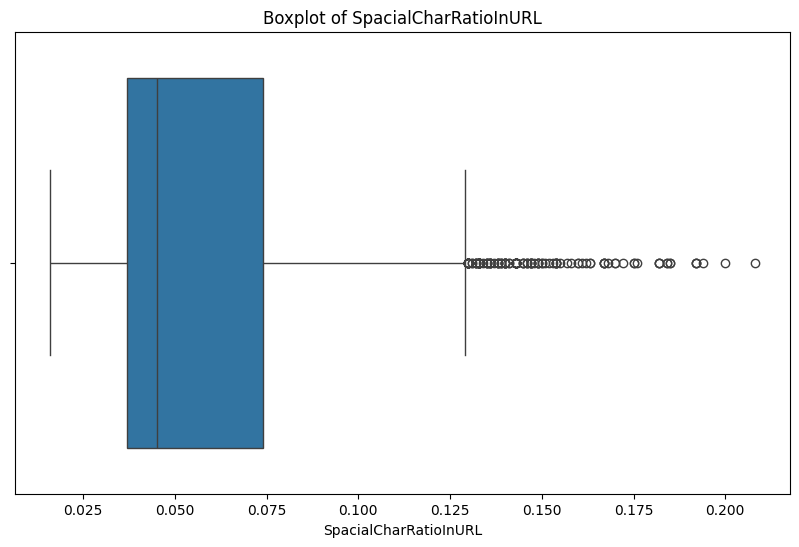

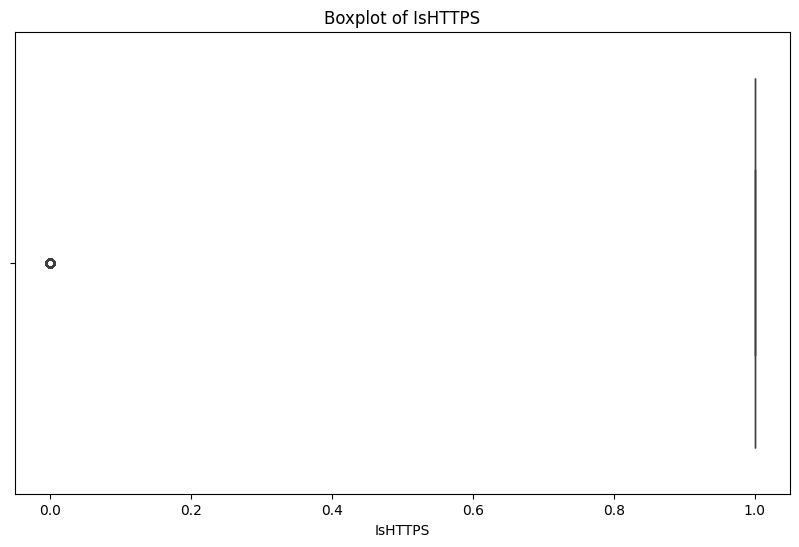

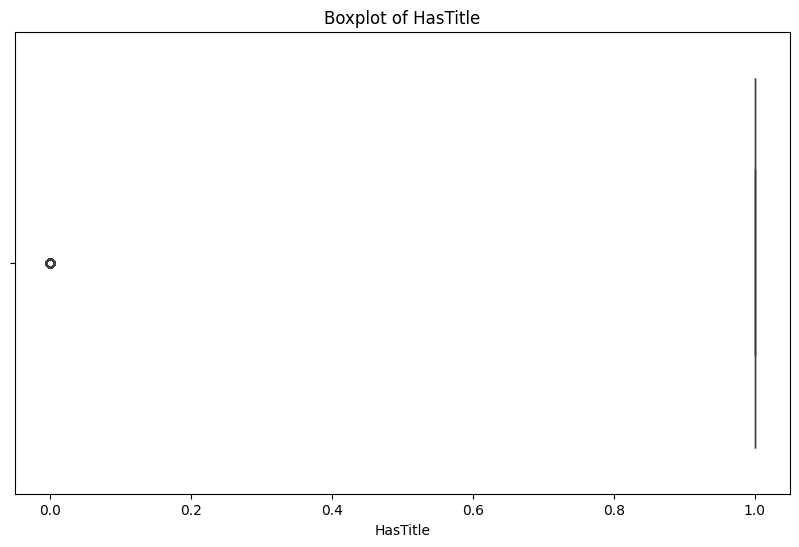

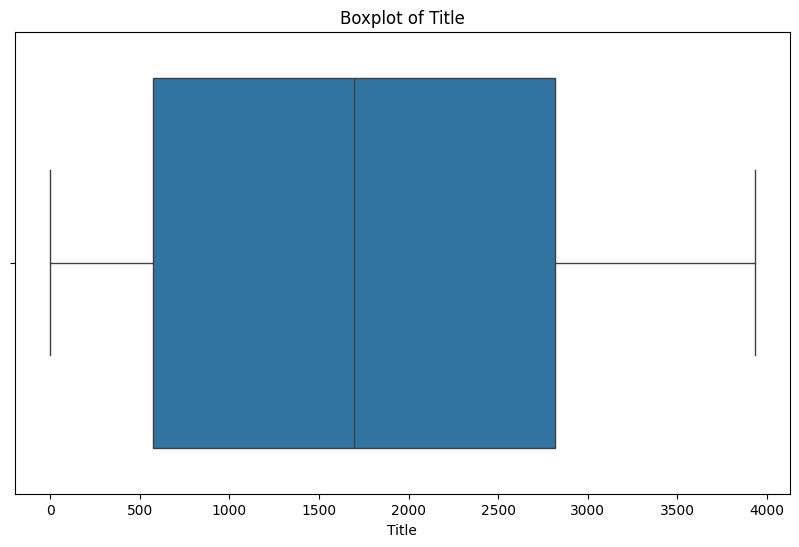

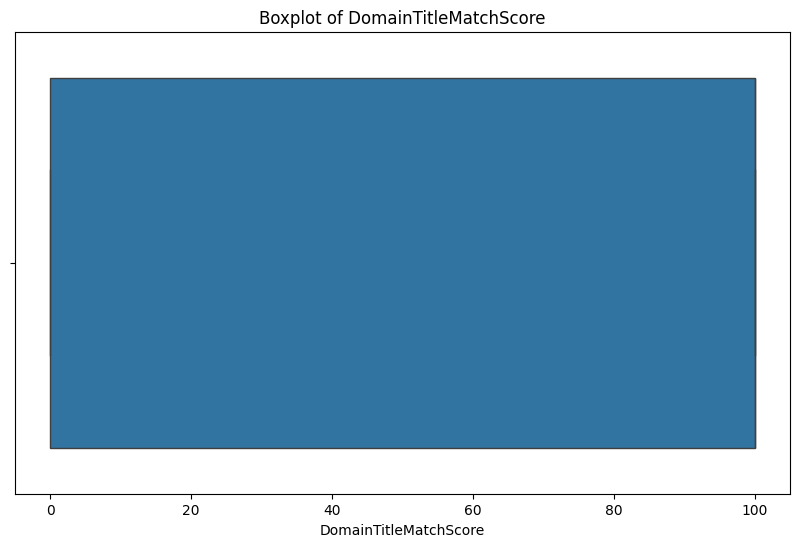

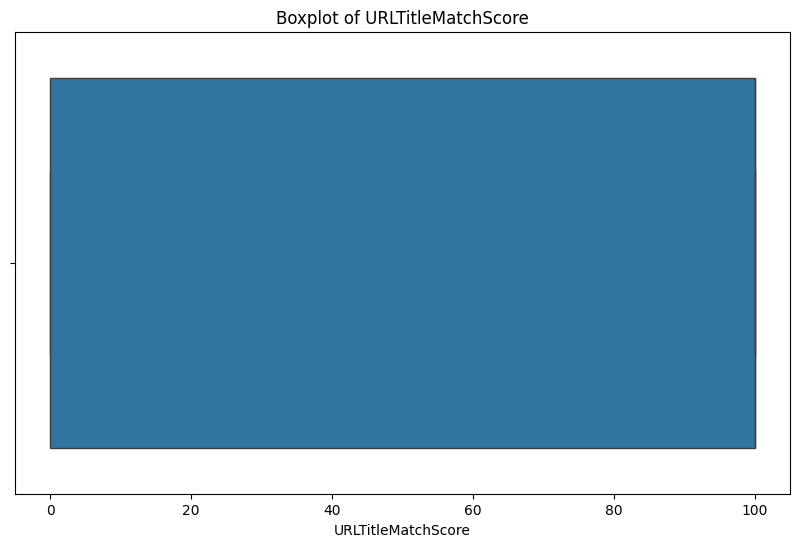

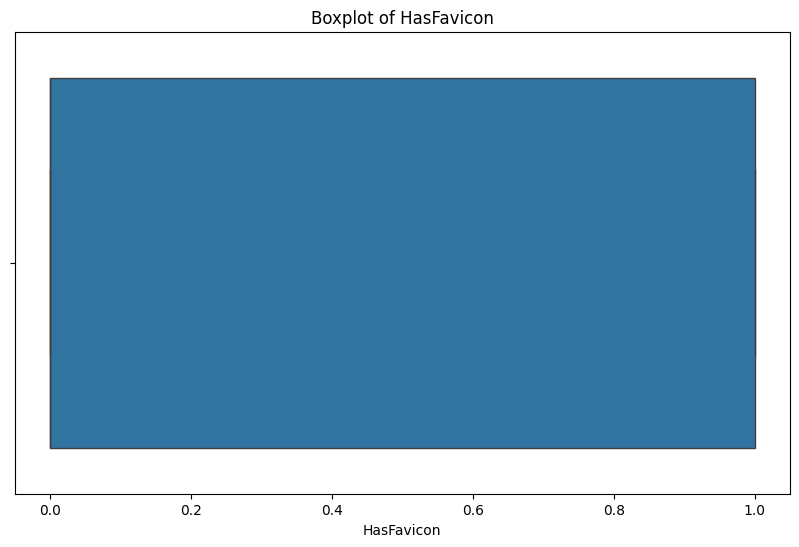

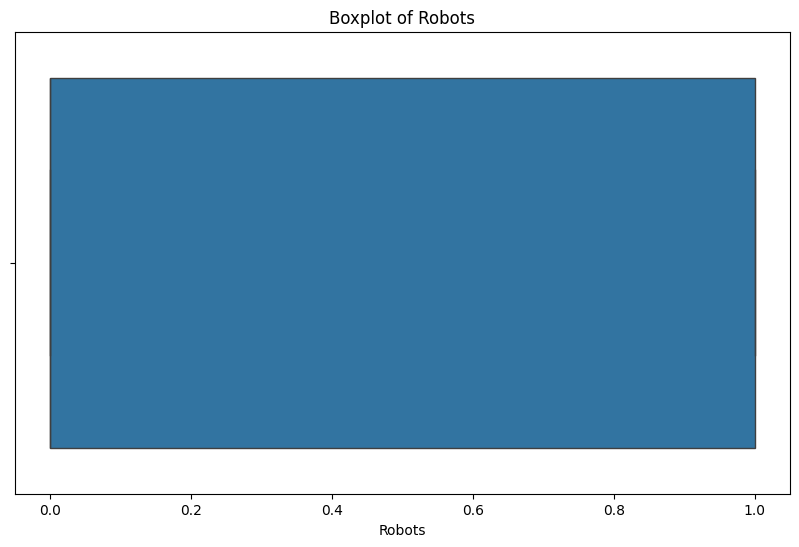

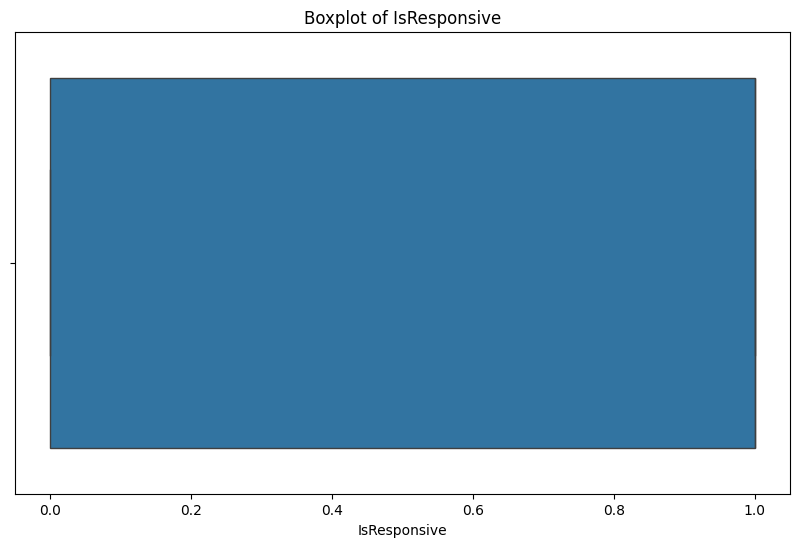

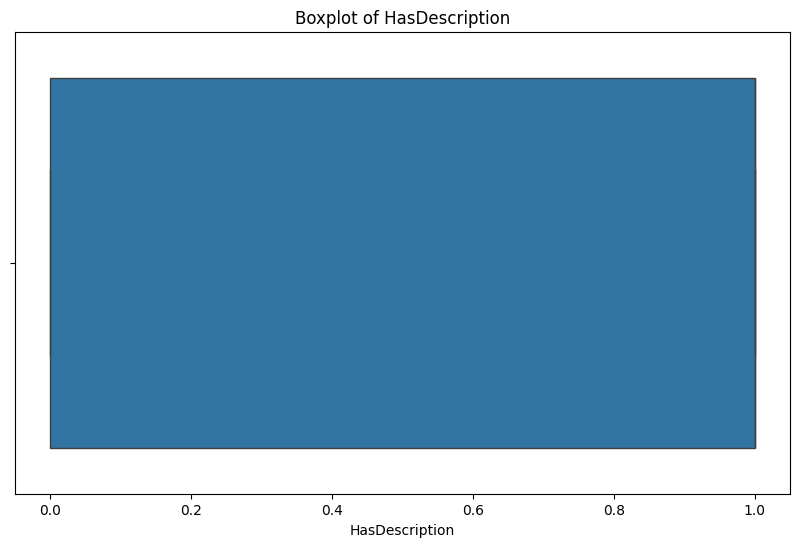

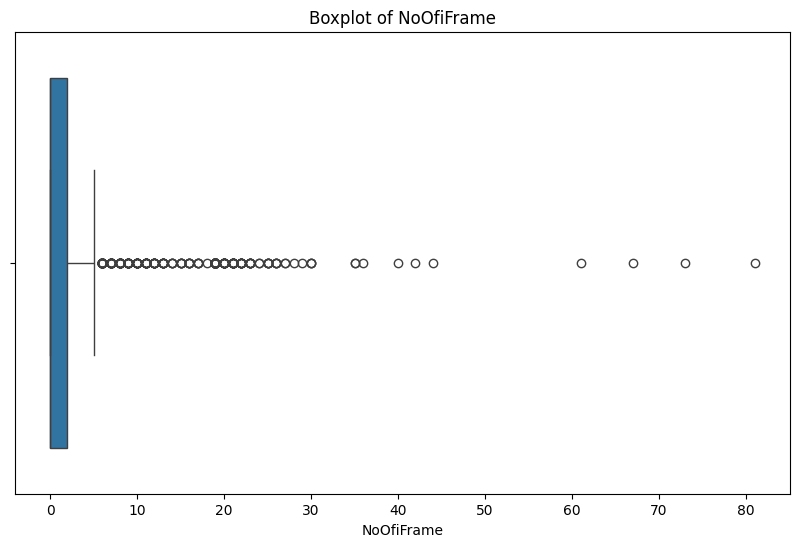

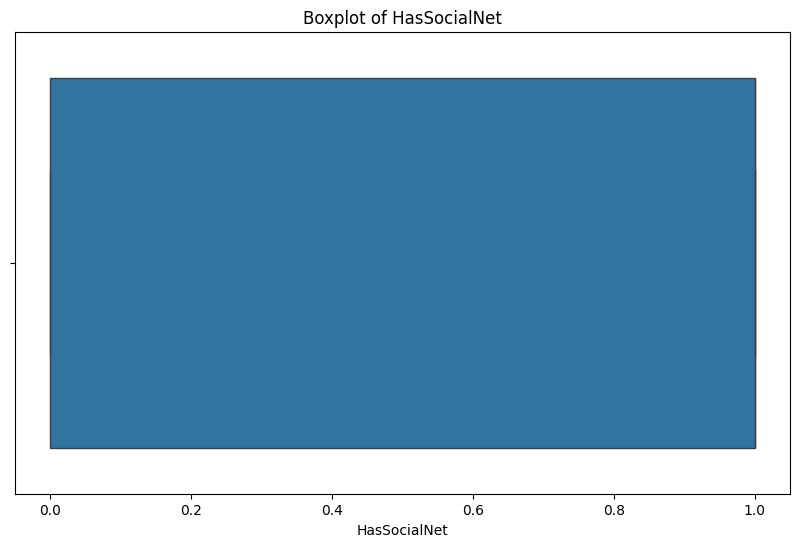

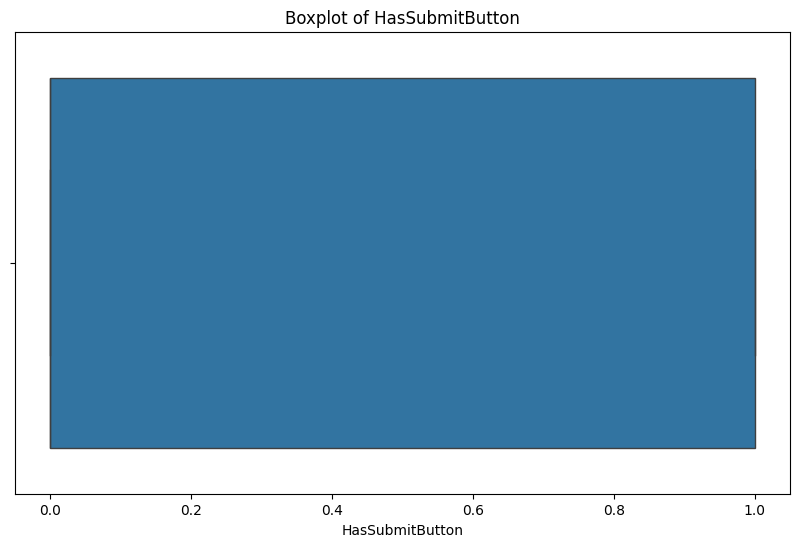

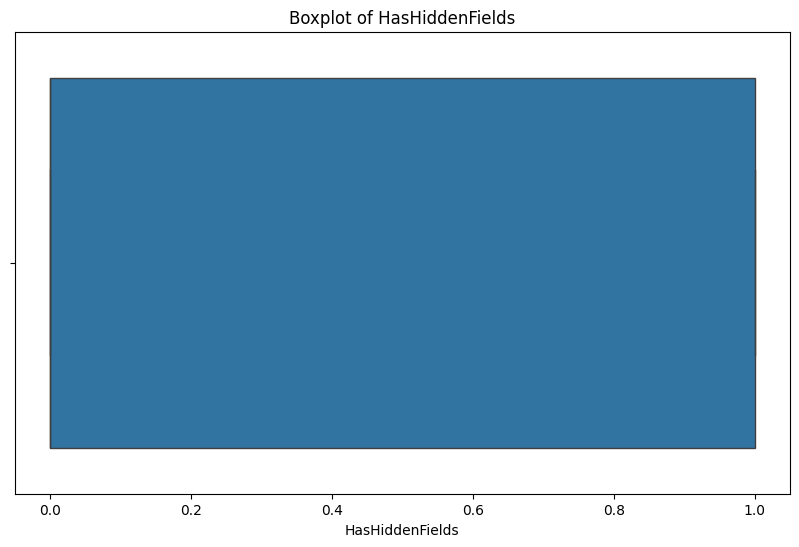

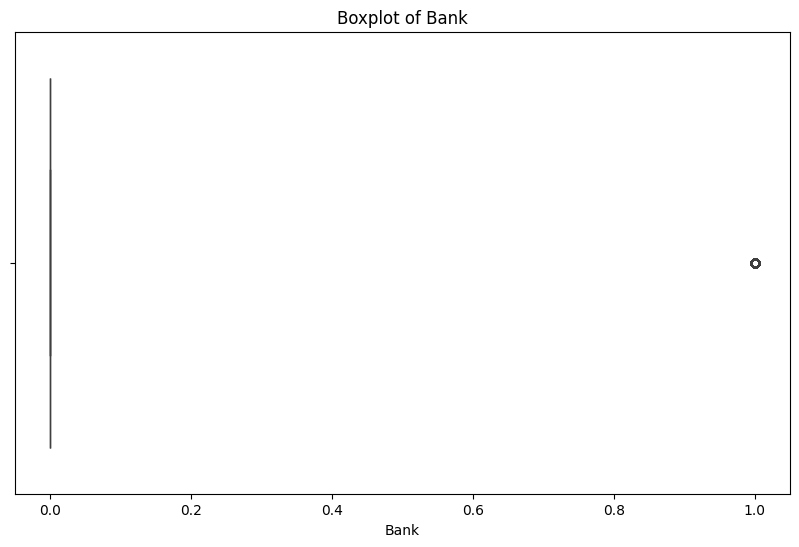

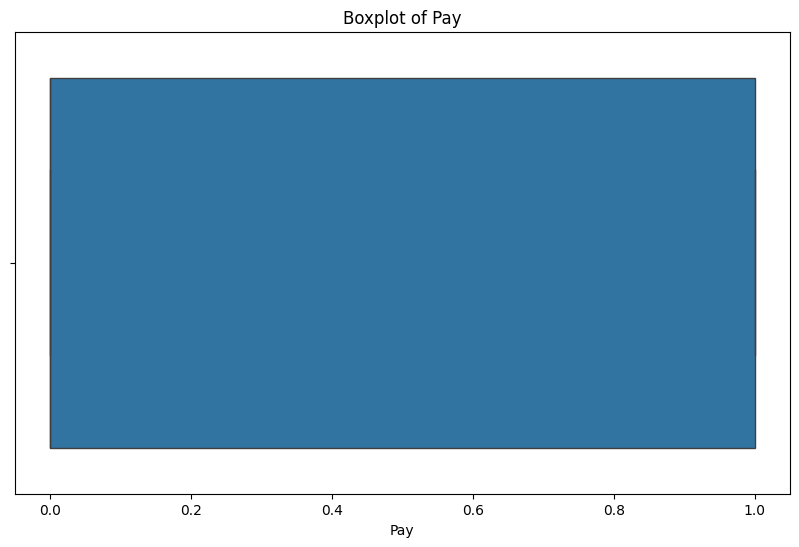

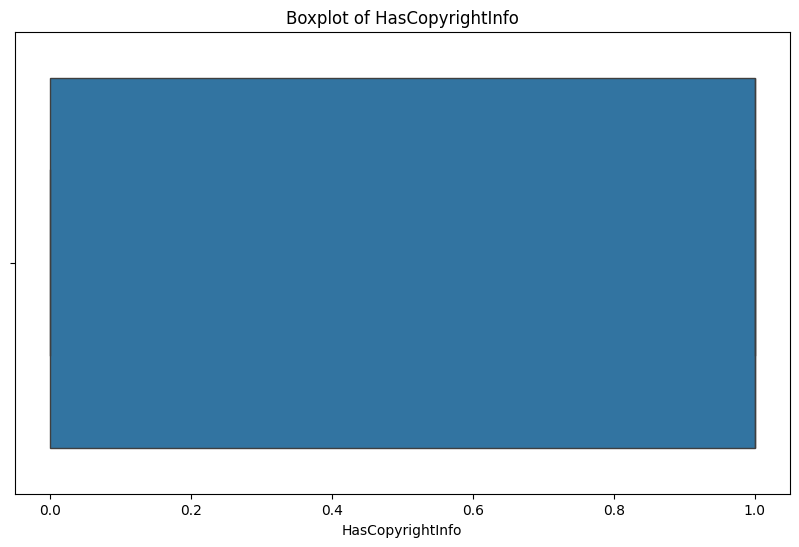

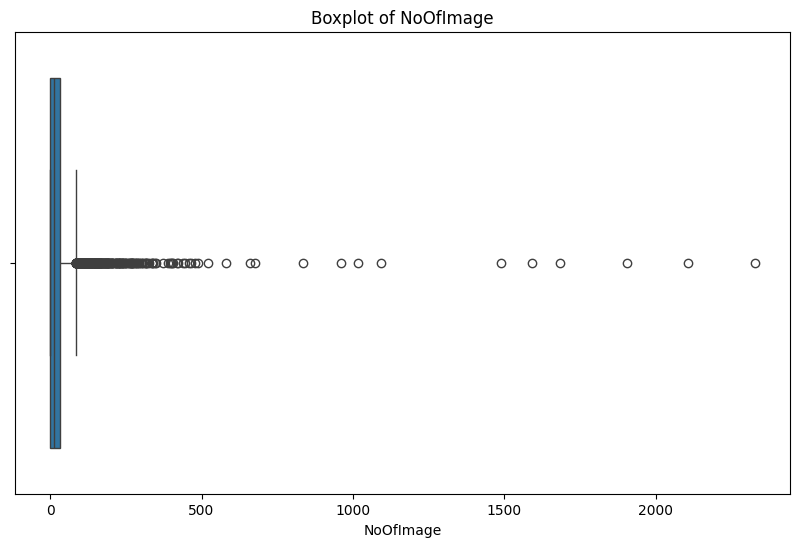

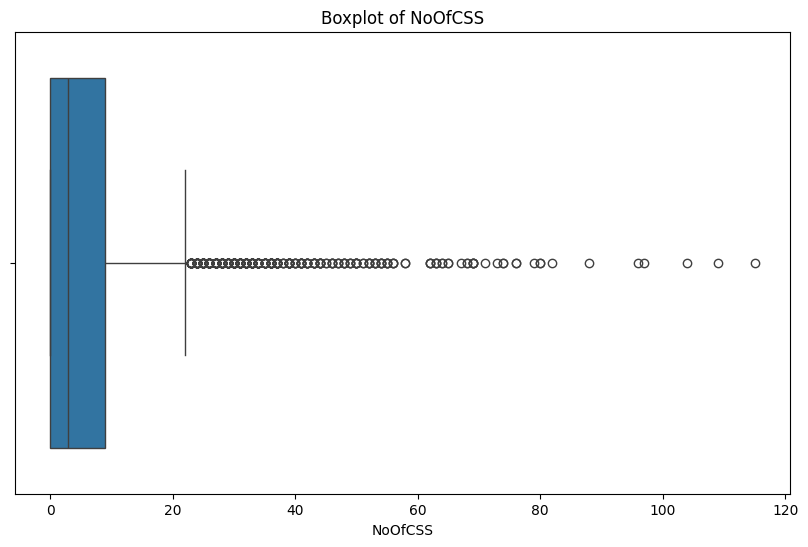

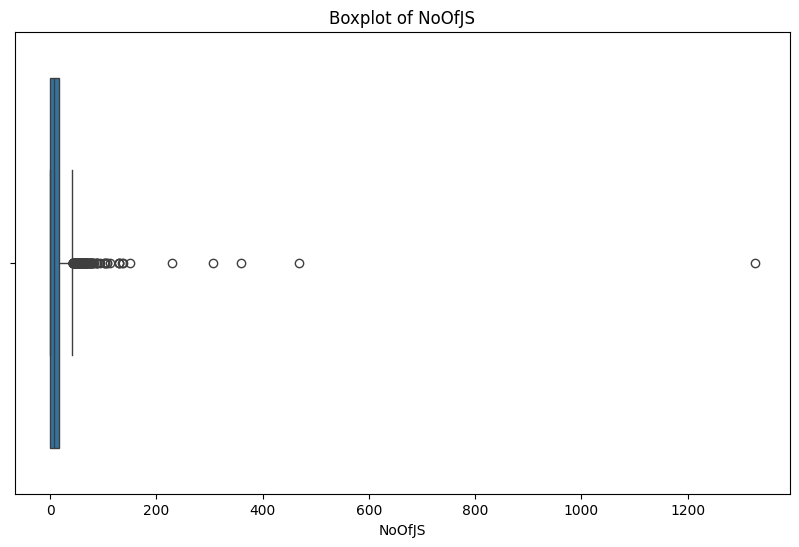

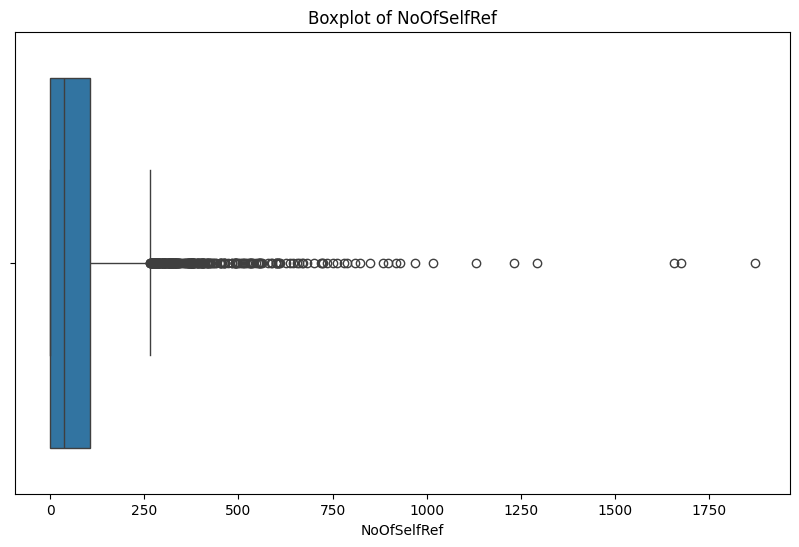

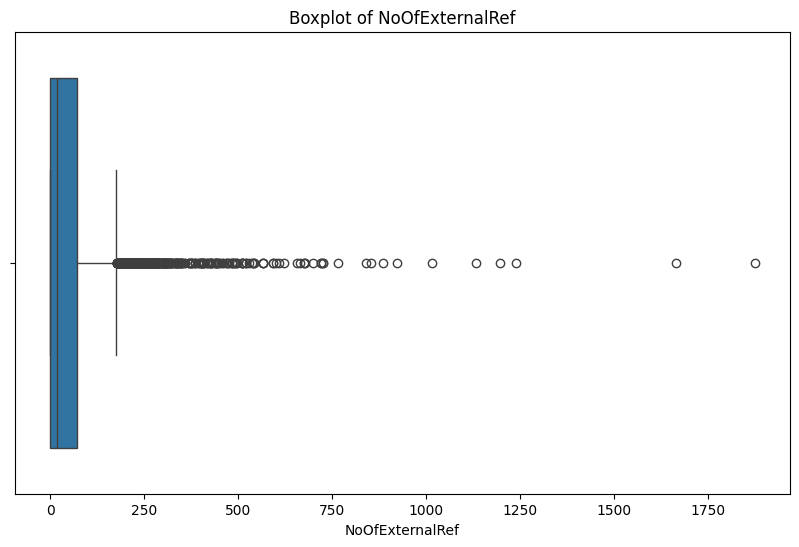

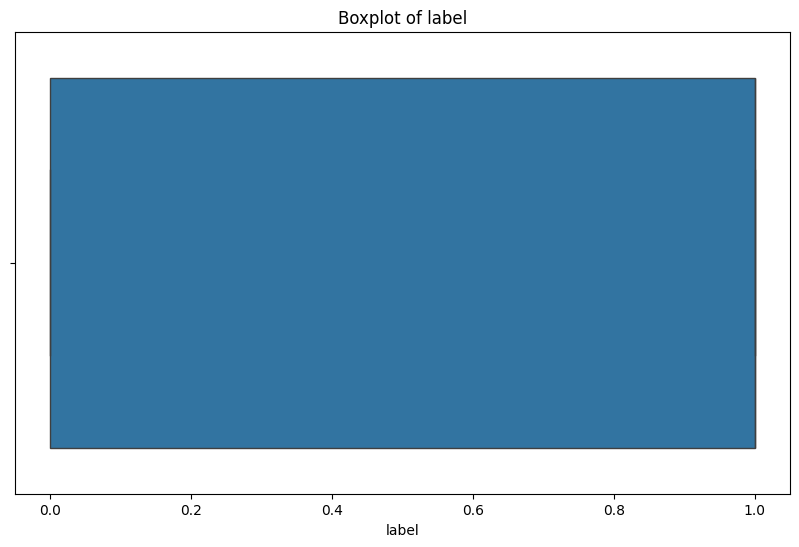

In [18]:
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

In [25]:
# Standardize features
X = data.drop(columns=['label'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Clustering

### Pre clustering PCA and t-SNE

In [26]:
# Step 1: Create the mask based on the original `X_scaled`
nan_mask = ~np.isnan(X_scaled).any(axis=1)  # True for rows without NaNs, False for rows with NaNs

# Step 2: Apply the mask to `X_scaled` and `data` to keep rows without NaNs in both
X_scaled = X_scaled[nan_mask]
data = data[nan_mask].reset_index(drop=True)  # Apply mask and reset index


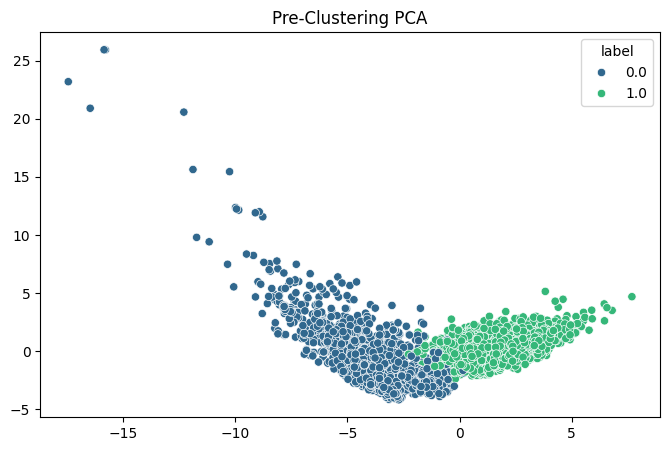

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['label'], palette="viridis")
plt.title('Pre-Clustering PCA')
plt.show()

In [28]:
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

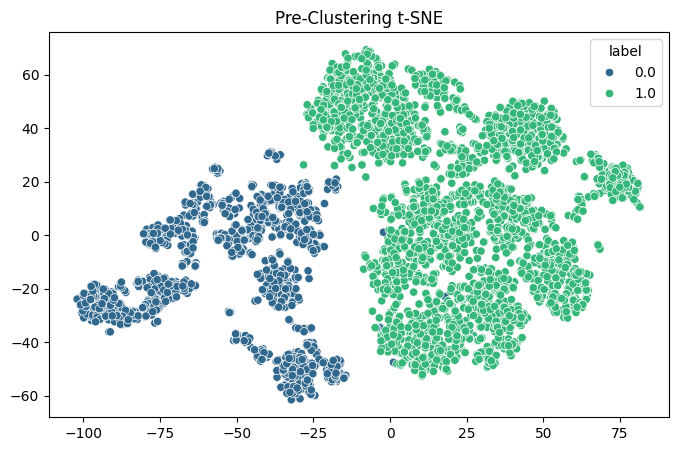

In [29]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=data['label'], palette="viridis")
plt.title('Pre-Clustering t-SNE')
plt.show()

### Dendogram

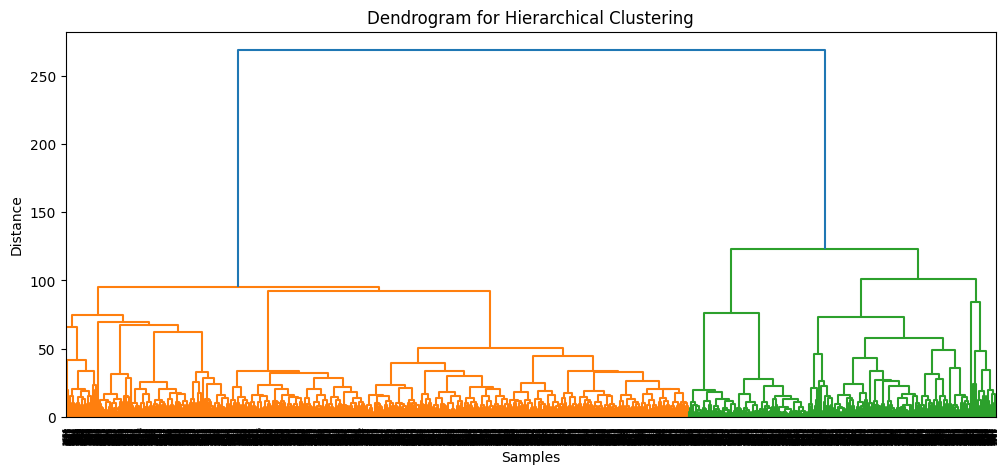

In [32]:
# Calculate linkage and plot dendrogram
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

### Heirarchical clustering

In [37]:
# Fit Agglomerative Clustering model
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
data['hierarchical_cluster'] = agg_clustering.fit_predict(X_scaled)

In [38]:
# Calculate Silhouette Score for Hierarchical Clustering
silhouette_score_hierarchical = silhouette_score(X_scaled, data['hierarchical_cluster'])
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_score_hierarchical:.4f}')

Silhouette Score for Hierarchical Clustering: 0.2673


### Post-Clustering t-SNE and PCA

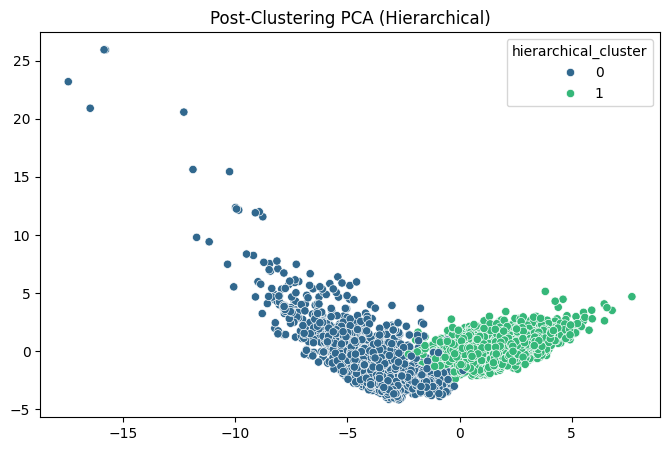

In [39]:
# Plot PCA and t-SNE after clustering
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['hierarchical_cluster'], palette="viridis")
plt.title('Post-Clustering PCA (Hierarchical)')
plt.show()

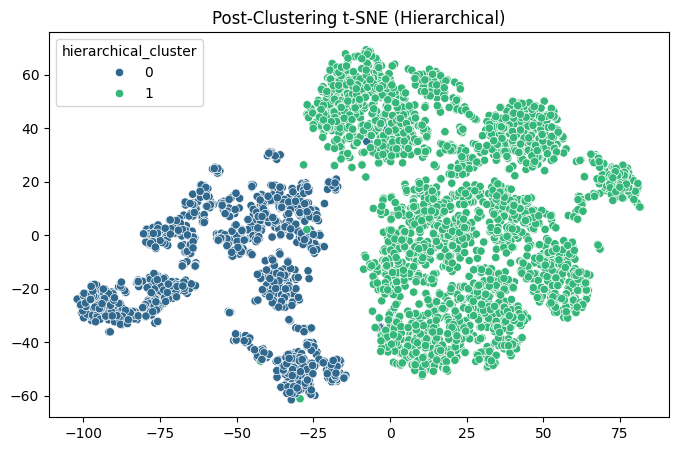

In [40]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=data['hierarchical_cluster'], palette="viridis")
plt.title('Post-Clustering t-SNE (Hierarchical)')
plt.show()

### Radar plot

In [44]:
cluster_centers = data.groupby('hierarchical_cluster').mean()
cluster_centers = cluster_centers.reset_index().melt(id_vars='hierarchical_cluster',
                                                     var_name='Feature',
                                                     value_name='Value')

fig = px.line_polar(cluster_centers,
                    r='Value',
                    theta='Feature',
                    color='hierarchical_cluster',
                    line_close=True,
                    template='plotly_dark',
                    labels={"hierarchical_cluster": "Cluster"})

fig.update_traces(fill='toself')  # Fill the radar areas
fig.show()

### Comparison with K-Means

In [45]:
# Fit K-Means model
kmeans = KMeans(n_clusters=2, random_state=0)
data['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [46]:
# Silhouette score for K-means
silhouette_score_kmeans = silhouette_score(X_scaled, data['kmeans_cluster'])

In [47]:
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_score_hierarchical:.4f}')
print(f'Silhouette Score for K-means: {silhouette_score_kmeans:.4f}')
print(f'Silhouette Score Difference (Hierarchical - K-Means): {silhouette_score_hierarchical - silhouette_score_kmeans:.4f}')

Silhouette Score for Hierarchical Clustering: 0.2673
Silhouette Score for K-means: 0.2674
Silhouette Score Difference (Hierarchical - K-Means): -0.0002


In [48]:
kmeans_centers = data.groupby('kmeans_cluster').mean()
kmeans_centers = kmeans_centers.reset_index().melt(id_vars='kmeans_cluster',
                                                   var_name='Feature',
                                                   value_name='Value')

# Step 2: Calculate average feature values for each Hierarchical cluster
hierarchical_centers = data.groupby('hierarchical_cluster').mean()
hierarchical_centers = hierarchical_centers.reset_index().melt(id_vars='hierarchical_cluster',
                                                               var_name='Feature',
                                                               value_name='Value')

In [49]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, subplot_titles=("K-means Clustering", "Hierarchical Clustering"),
                    specs=[[{'type': 'polar'}, {'type': 'polar'}]])

for cluster in kmeans_centers['kmeans_cluster'].unique():
    fig.add_trace(
        go.Scatterpolar(
            r=kmeans_centers[kmeans_centers['kmeans_cluster'] == cluster]['Value'],
            theta=kmeans_centers[kmeans_centers['kmeans_cluster'] == cluster]['Feature'],
            fill='toself',
            name=f"K-means Cluster {cluster}"
        ),
        row=1, col=1
    )

for cluster in hierarchical_centers['hierarchical_cluster'].unique():
    fig.add_trace(
        go.Scatterpolar(
            r=hierarchical_centers[hierarchical_centers['hierarchical_cluster'] == cluster]['Value'],
            theta=hierarchical_centers[hierarchical_centers['hierarchical_cluster'] == cluster]['Feature'],
            fill='toself',
            name=f"Hierarchical Cluster {cluster}"
        ),
        row=1, col=2
    )

fig.update_layout(
    title="Comparison of K-means and Hierarchical Clustering",
    showlegend=True,
    template="plotly_dark"
)

# Show plot
fig.show()